In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Notes:

Net generation excludes electricity use for power plant operations.
Terawatt hours, abbreviated as TWh, is a unit of energy representing one trillion watt hours.

Important links

[Electricity generation, capacity, and sales in the United States
](https://www.eia.gov/energyexplained/electricity/electricity-in-the-us-generation-capacity-and-sales.php#:~:text=In%202022%2C%20net%20generation%20of,solar%20photovoltaic%20(PV)%20systems.)



Created a python package to download our data from the EIA website

In [24]:
from EIA_DATA.data import get_generation_data

In [25]:
raw_df = get_generation_data()

When we got the data from the excel file it grabbed rows above the headers. We can find all values in the 'YEAR' column and remove them from the dataframe. We can also remove rows that have values that are NaN. We can also check the integrity of the data by looking for duplicate rows. 

In [26]:
invalid_rows = raw_df[raw_df['YEAR'].str.isnumeric() == False]
df = raw_df.drop(invalid_rows.index).dropna()
df.duplicated().sum()



0

To ensure we didn't have change our data too much we check the shape of the dataframe before and after.

In [27]:
print("Shape of raw_df:")
print(raw_df.shape)

print("\nShape of df:")
print(df.shape)

removed_rows = raw_df.shape[0] - df.shape[0]
print(f'We removed {removed_rows} row(s).')

Shape of raw_df:
(530838, 6)

Shape of df:
(530790, 6)
We removed 48 row(s).


We can change the date types to make our data easier to work with. Then check what they are after we have changed them.

In [28]:
df = df.infer_objects()
df.dtypes


YEAR                            int64
MONTH                           int64
STATE                          object
TYPE OF PRODUCER               object
ENERGY SOURCE                  object
GENERATION (Megawatthours)    float64
dtype: object

We want to take the year and month columns and convert them into a date colum we can use to index the dataframe. We dont have a day of the month so we just use a constant value of 1. We can not get rid of the year and month columns to clean up the dataframe. 

In [29]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(day=1),errors='coerce')
df.set_index('DATE', inplace=True)
df.drop(['YEAR', 'MONTH'], axis=1, inplace=True)


In [30]:
df

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
DATE,,,,
2001-01-01,AK,Total Electric Power Industry,Coal,46903.0
2001-01-01,AK,Total Electric Power Industry,Petroleum,71085.0
2001-01-01,AK,Total Electric Power Industry,Natural Gas,367521.0
2001-01-01,AK,Total Electric Power Industry,Hydroelectric Conventional,104549.0
2001-01-01,AK,Total Electric Power Industry,Wind,87.0
...,...,...,...,...
2023-09-01,WY,"Electric Generators, Electric Utilities",Coal,2635451.0
2023-09-01,WY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,39490.0
2023-09-01,WY,"Electric Generators, Electric Utilities",Natural Gas,95639.0


Converting the 'STATE' column to uppercase ensures a consistent and standardized representation of state names.

In [31]:
df['STATE'] = df['STATE'].str.upper()

To better understand our data we can get all they types of producers and the types of energy sources by using the .unique() method. This will also help us validate that we cleaned the data correctly. 

In [32]:
types_producer = df['TYPE OF PRODUCER'].unique()
types_producer

array(['Total Electric Power Industry',
       'Electric Generators, Electric Utilities',
       'Combined Heat and Power, Electric Power',
       'Combined Heat and Power, Commercial Power',
       'Combined Heat and Power, Industrial Power',
       'Electric Generators, Independent Power Producers'], dtype=object)

We can see there are really three categories in the producer columns. 
- Electric Generators
- Combined Heat and Power
- Total Electric Power Industry

Each have a subcategory too.

We can do the same for the Energy Source column

In [33]:
df['ENERGY SOURCE'].unique()
#COULD BE A PROBELM LOOKS LIKE THE HEADER IS IN THE DATA TOO.

array(['Coal', 'Petroleum', 'Natural Gas', 'Hydroelectric Conventional',
       'Wind', 'Total', 'Other Gases', 'Nuclear',
       'Wood and Wood Derived Fuels', 'Other Biomass', 'Other',
       'Solar Thermal and Photovoltaic', 'Pumped Storage', 'Geothermal'],
      dtype=object)

We can check on 'GENERATION (Megawatthours)' column and get some statistics that will describe our dataset. 

In [34]:
df['GENERATION (Megawatthours)'].describe()

count    5.307900e+05
mean     1.390318e+06
std      1.078577e+07
min     -9.978550e+05
25%      1.573685e+03
50%      2.291650e+04
75%      2.779502e+05
max      4.256113e+08
Name: GENERATION (Megawatthours), dtype: float64

We see that our standard diviation is very high and there is a large gap between the percentiles. This tell us that there is many outliers and values that are zero. Anohter thing to note is that the min value is a negitive number. This is data on the generaion of electiricy so we went to know why type of energy source is pulling power instead of producing it. 

We can plot a histogram to see how the data is distributed and get a visual representation. 

<Axes: >

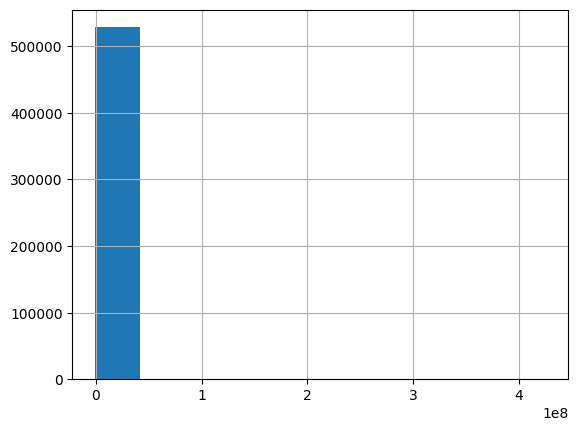

In [35]:
df['GENERATION (Megawatthours)'].hist()
#come back and add label and a title


The visual representation validates our observations from the describe() table, indicating a concentration of values around zero and notable outliers at the upper end. However, it's important to note that this graph represents a broad overview, encompassing diverse sources, states, and their totals spanning from 2001 to 2023. To narrow our focus and derive more targeted insights, we plan to apply filters, selecting specific subsets of data such as totals, specific sources, or particular states for further analysis.

In [36]:
df['TYPE OF PRODUCER'].value_counts()


TYPE OF PRODUCER
Total Electric Power Industry                       143564
Electric Generators, Electric Utilities             100222
Electric Generators, Independent Power Producers     95985
Combined Heat and Power, Industrial Power            82955
Combined Heat and Power, Commercial Power            58112
Combined Heat and Power, Electric Power              49952
Name: count, dtype: int64

The unit Megawatt-hours (MWh) is very small when dealing with net generation so we will reduce it to make it more manageable. We are going to use a Terawatt-hour (TWh) which is equal to 1 million Megawatt-hours. For reference the average house hold uses 10,632 kilowatt-hours per year or .00001063 TWh.

In [37]:
df["Generation (TWh)"] = df["GENERATION (Megawatthours)"]/1000000
df.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)



In [38]:
df = df.infer_objects()
df.dtypes

STATE                object
TYPE OF PRODUCER     object
ENERGY SOURCE        object
Generation (TWh)    float64
dtype: object

Now that we have our data cleaned we will make a copy of the data frame to hold entegrity of the data

In [39]:
df_copy = df.copy()
df_copy.shape

(530790, 4)

We will also make the df into a csv of the whole df

In [40]:
df_reset = df.reset_index()
df_reset.to_csv('net_generation_df.csv', index=True)

# Start of analysis

### Understanding the Total electric power generation

We will start our analysis on the 'Total Electric Power Industry' to begin

Totals are already calculated in the df so we will just need to pull the right columns.

In [41]:
total=df.loc[df['TYPE OF PRODUCER']=='Total Electric Power Industry']

In [42]:
df['STATE'].value_counts().head()

STATE
US-TOTAL    19506
CA          16495
MI          15090
PA          14070
NY          13791
Name: count, dtype: int64

In [43]:
US_total=total.loc[total['STATE']=='US-TOTAL']

In [44]:
US_total['ENERGY SOURCE'].value_counts()


ENERGY SOURCE
Coal                              273
Petroleum                         273
Natural Gas                       273
Other Gases                       273
Nuclear                           273
Hydroelectric Conventional        273
Wind                              273
Solar Thermal and Photovoltaic    273
Wood and Wood Derived Fuels       273
Geothermal                        273
Other Biomass                     273
Pumped Storage                    273
Other                             273
Total                             273
Name: count, dtype: int64

In [45]:
US_source=US_total.groupby(by=[US_total.index,"ENERGY SOURCE"]).sum().reset_index()

We need to get rid of the Total value in the ENERGY SOURCE  column so we dont double count

In [46]:
US_source=US_source[(US_source['ENERGY SOURCE']!='Total')]

In [47]:
US_source[['DATE','ENERGY SOURCE','Generation (TWh)']].head()

,DATE,ENERGY SOURCE,Generation (TWh)
0,2001-01-01,Coal,177.287111
1,2001-01-01,Geothermal,1.229325
2,2001-01-01,Hydroelectric Conventional,18.852048
3,2001-01-01,Natural Gas,42.388663
4,2001-01-01,Nuclear,68.707077


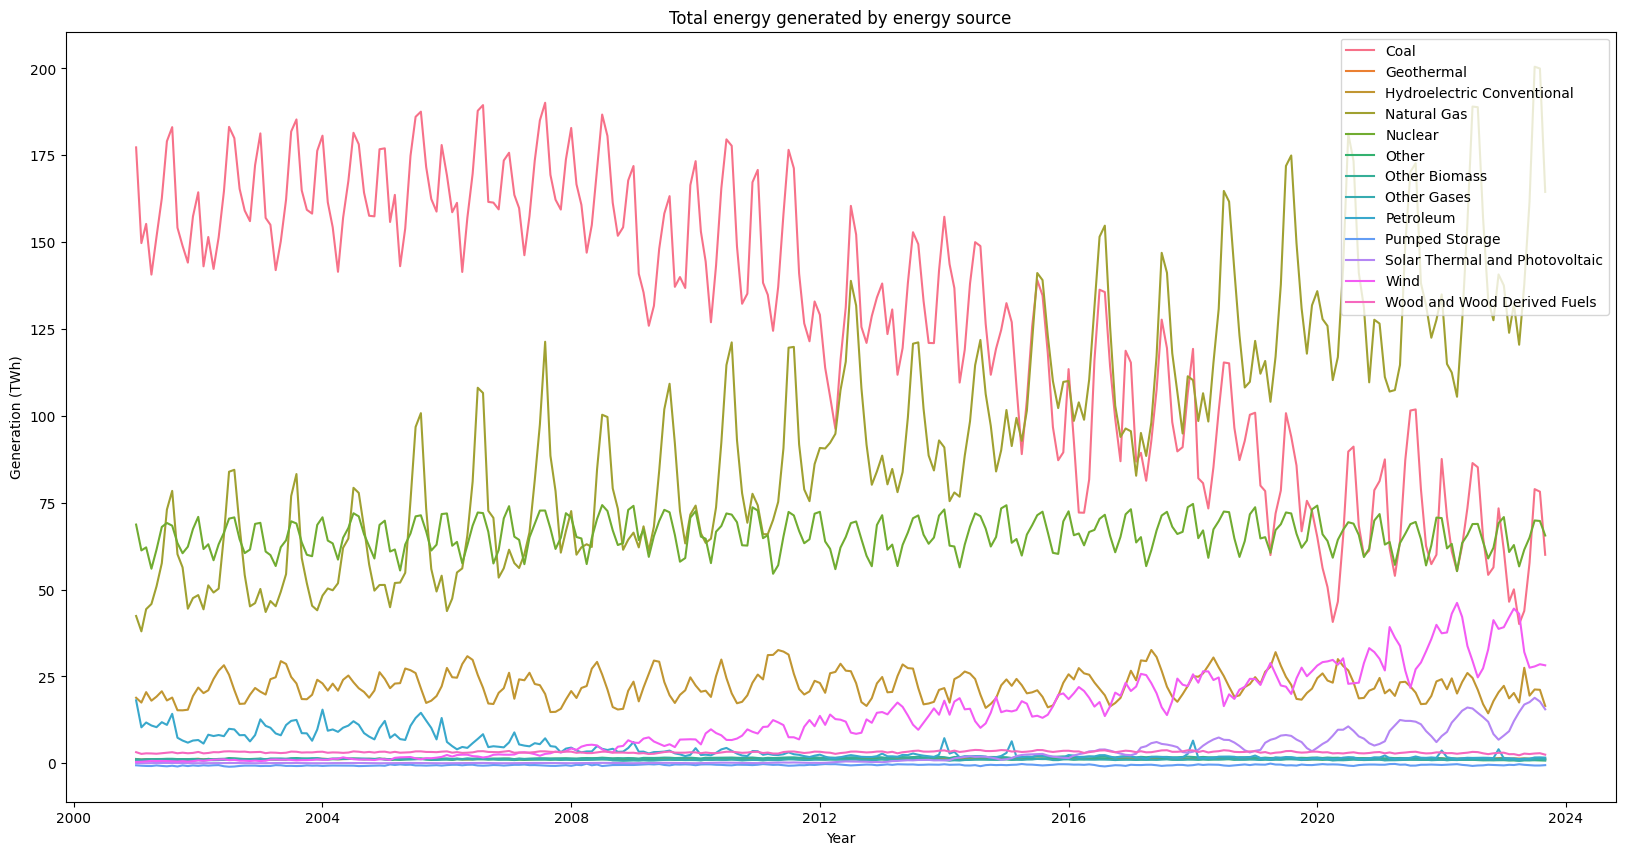

In [48]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_source, x=US_source['DATE'] \
             ,y=US_source['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by energy source")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show()

In [49]:
top_3 = ['Coal' ,'Natural Gas', 'Nuclear'] 
US_top3=US_source[US_source['ENERGY SOURCE'].isin(top_3)]

In [50]:
US_top3

,DATE,ENERGY SOURCE,STATE,TYPE OF PRODUCER,Generation (TWh)
0,2001-01-01,Coal,US-TOTAL,Total Electric Power Industry,177.287111
3,2001-01-01,Natural Gas,US-TOTAL,Total Electric Power Industry,42.388663
4,2001-01-01,Nuclear,US-TOTAL,Total Electric Power Industry,68.707077
14,2001-02-01,Coal,US-TOTAL,Total Electric Power Industry,149.735484
17,2001-02-01,Natural Gas,US-TOTAL,Total Electric Power Industry,37.966927
...,...,...,...,...,...
3797,2023-08-01,Natural Gas,US-TOTAL,Total Electric Power Industry,199.993042
3798,2023-08-01,Nuclear,US-TOTAL,Total Electric Power Industry,69.744023
3808,2023-09-01,Coal,US-TOTAL,Total Electric Power Industry,60.005676
3811,2023-09-01,Natural Gas,US-TOTAL,Total Electric Power Industry,164.466357


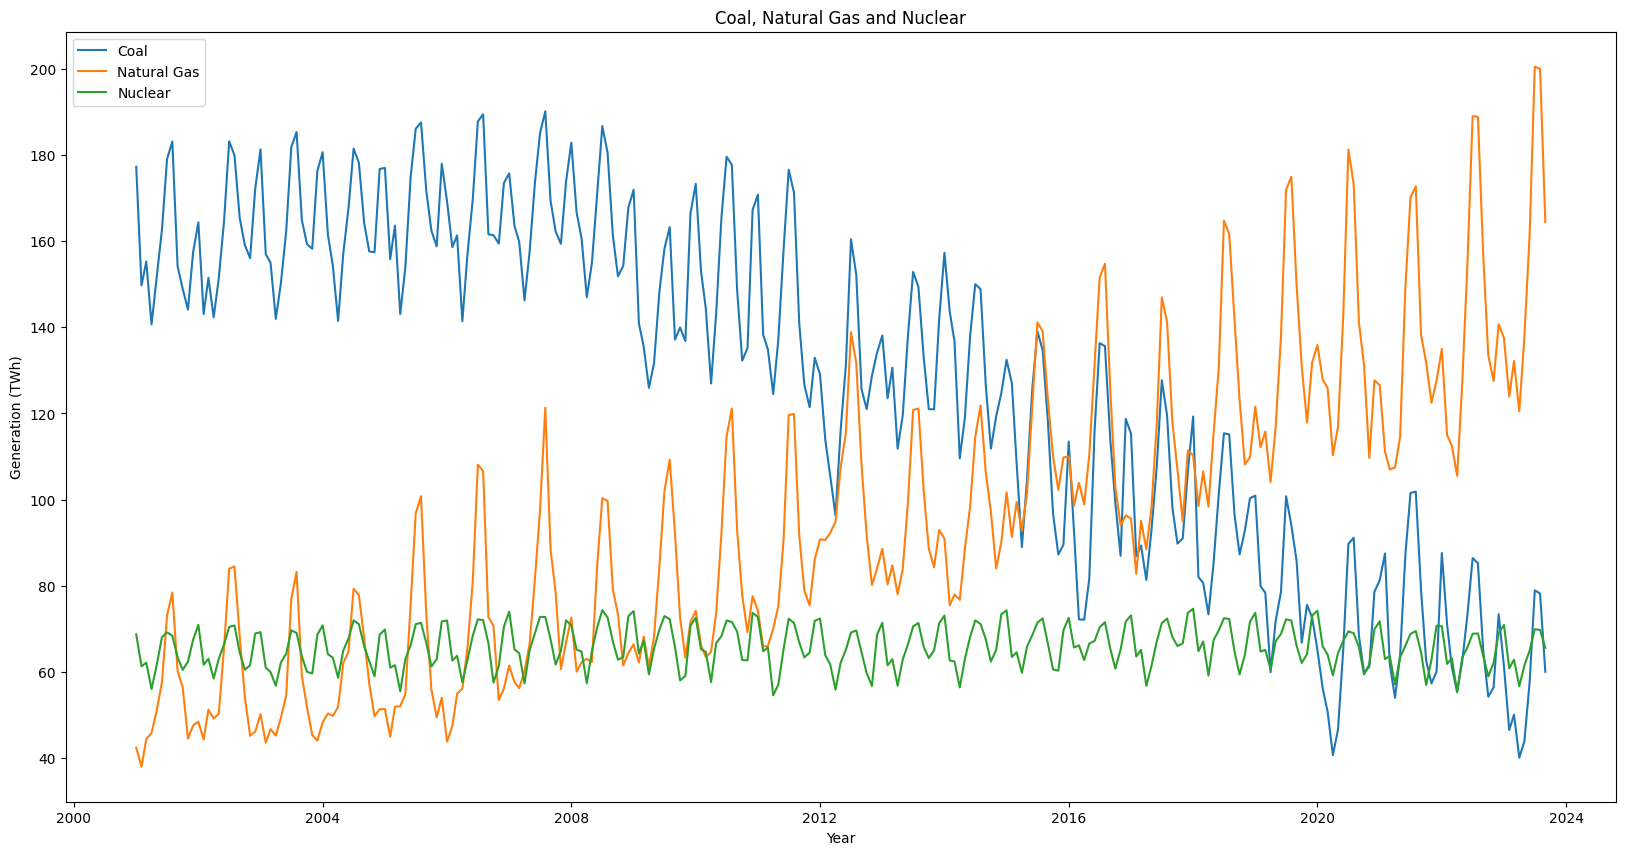

In [51]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_top3, x=US_top3['DATE'] ,y=US_top3['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Coal, Natural Gas and Nuclear")
plt.xlabel("Year")
plt.legend(loc='best')

In [52]:
snd_4 = ['Wind' ,'Hydroelectric Conventional', 'Solar Thermal and Photovoltaic', 'Petroleum'] 
US_snd4=US_source[US_source['ENERGY SOURCE'].isin(snd_4)]

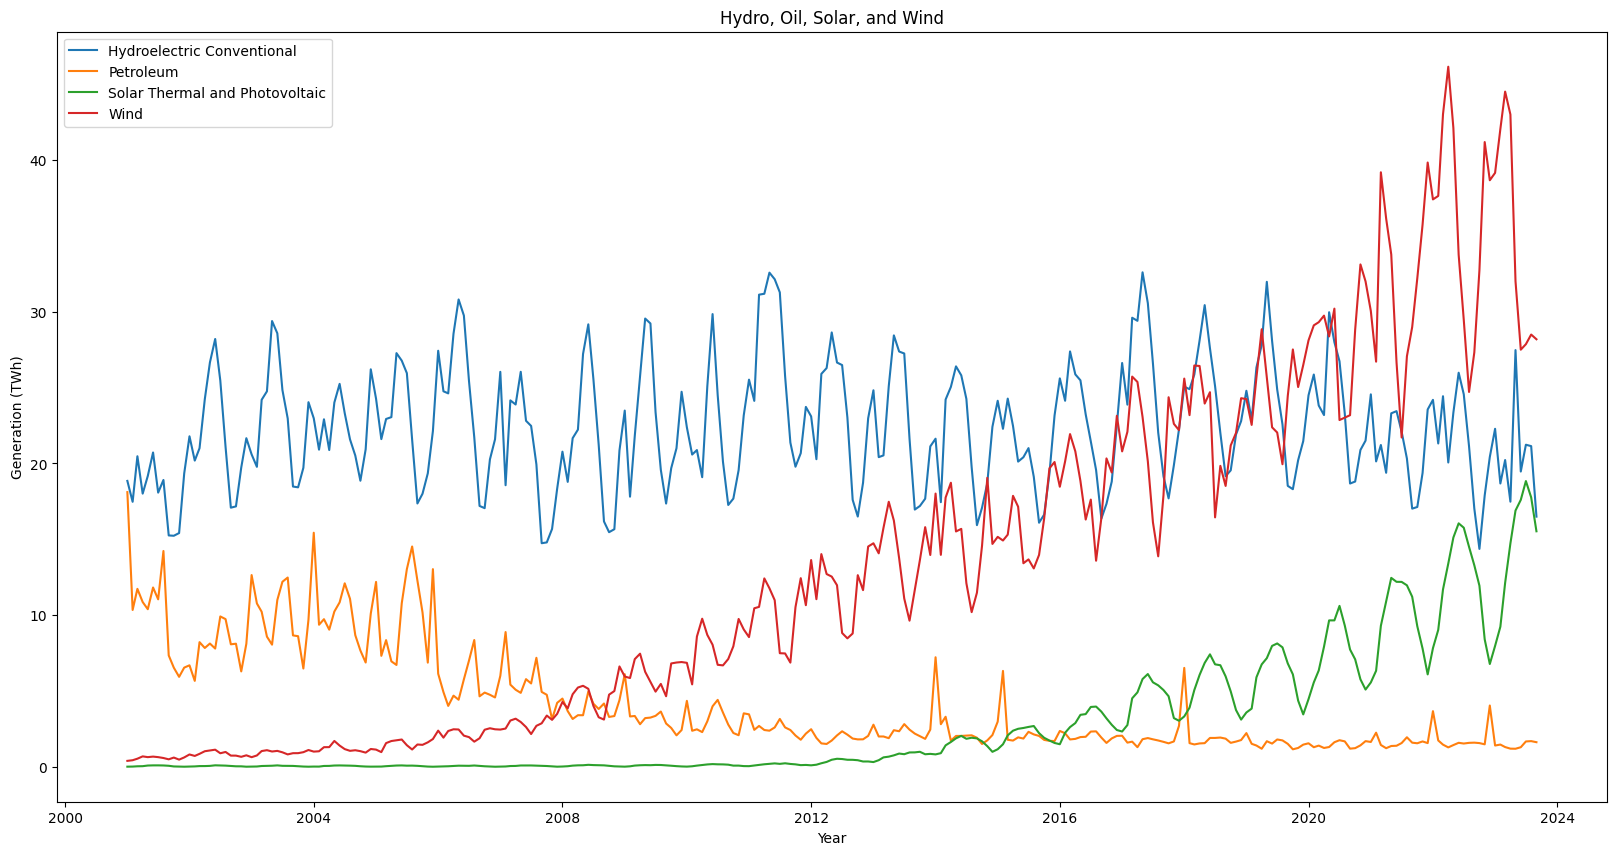

In [53]:
plt.figure(figsize=(20,10))
sns.color_palette("viridis")
sns.lineplot(data=US_snd4, x=US_snd4['DATE'] ,y=US_snd4['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Hydro, Oil, Solar, and Wind")
plt.xlabel("Year")
plt.legend(loc='best')

In [54]:
bottom=['Other','Other Gases','Pumped Storage','Wood and Wood Derived Fuels'\
        ,'Other Biomass','Geothermal']
US_bot=US_source[US_source['ENERGY SOURCE'].isin(bottom)]

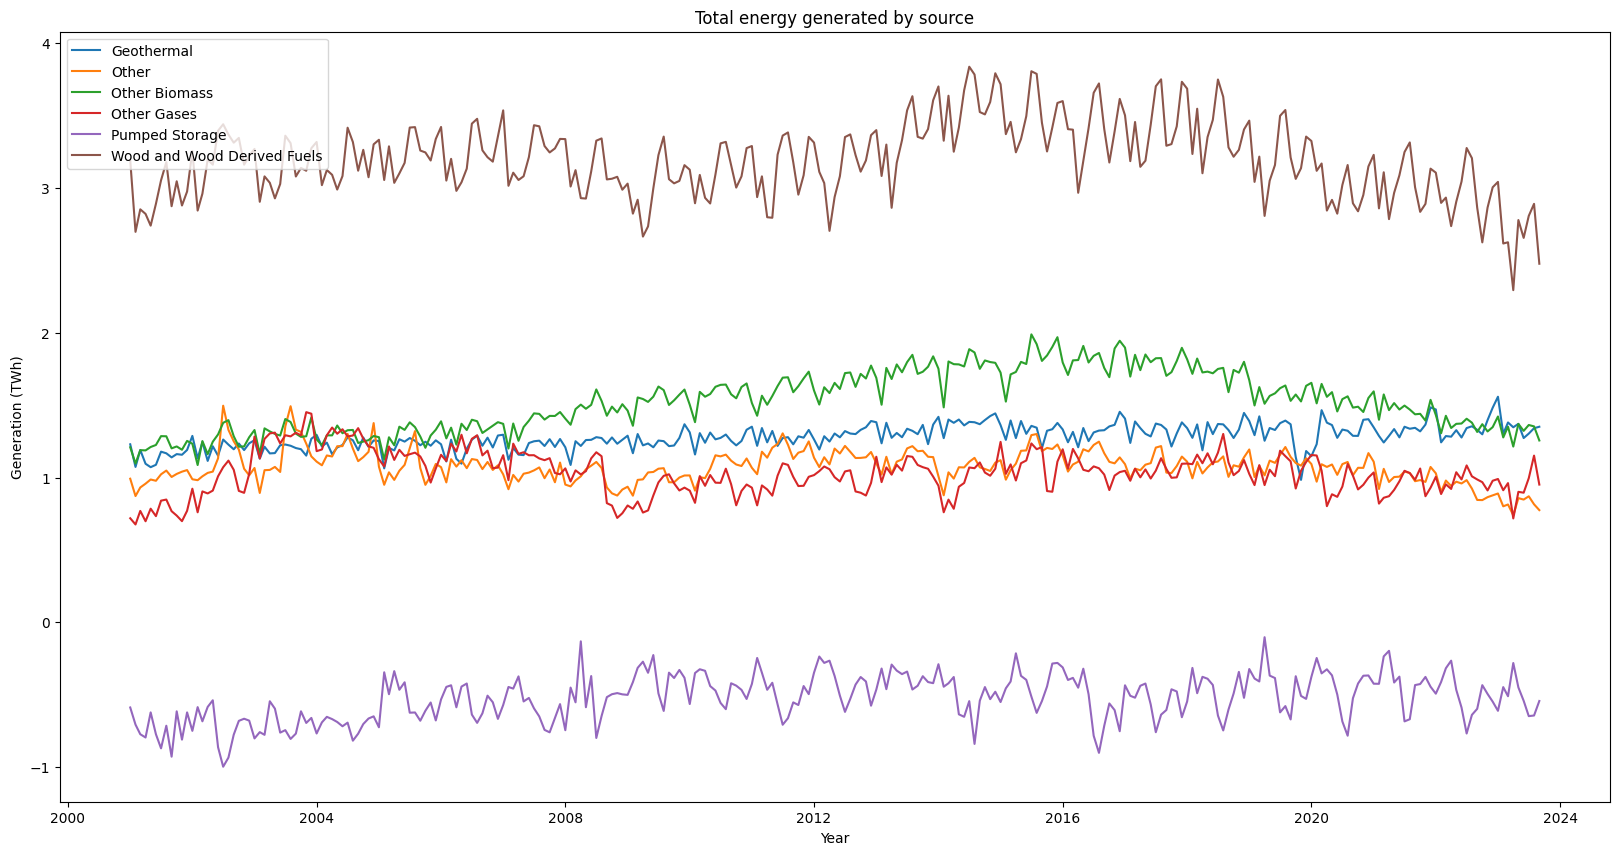

In [55]:
plt.figure(figsize=(20,10))
sns.color_palette("deep")
sns.lineplot(data=US_bot, x=US_bot['DATE'] ,y=US_bot['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by source")
plt.xlabel("Year")
plt.legend(loc='upper left')

NameError: name 'US_nat' is not defined

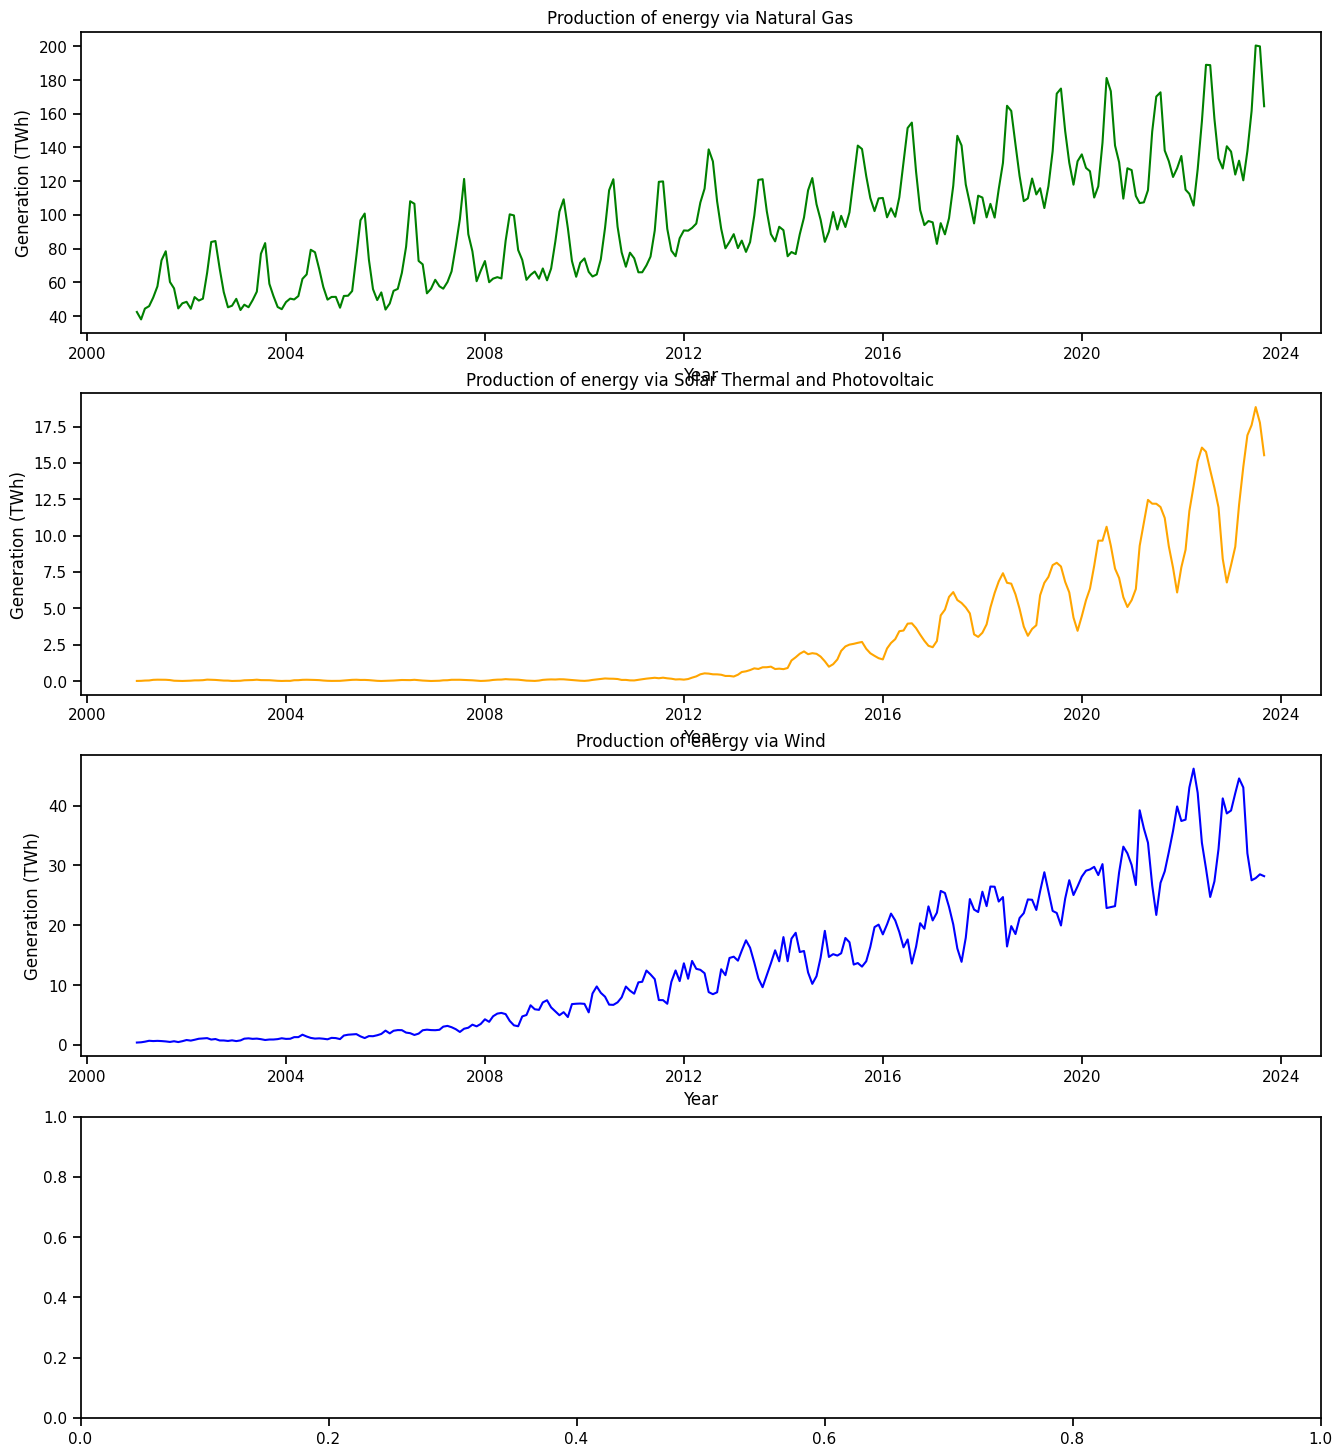

In [56]:
def plot_energy_source(ax, df, energy_source, color):
    subset = df.loc[df['ENERGY SOURCE'] == energy_source]
    sns.lineplot(x=subset.index, y=subset['Generation (TWh)'], color=color, ax=ax)
    ax.set_title(f'Production of energy via {energy_source}')
    ax.set_xlabel("Year")
    ax.set_ylabel("Generation (TWh)")
    
sns.set_context("notebook")
fig, axs = plt.subplots(4, 1, figsize=(16, 18))  # Adjusted figure size

plot_energy_source(axs[0], US_total, 'Natural Gas', 'green')
plot_energy_source(axs[1], US_total, 'Solar Thermal and Photovoltaic', 'orange')
plot_energy_source(axs[2], US_total, 'Wind', 'blue')
ax_combined = axs[3]
sns.lineplot(x=US_nat.index, y=US_nat['Generation (TWh)'], color='green', ax=ax_combined)
sns.lineplot(x=US_sol.index, y=US_sol['Generation (TWh)'], color='orange', ax=ax_combined)
sns.lineplot(x=US_wind.index, y=US_wind['Generation (TWh)'], color='blue', ax=ax_combined)
ax_combined.set_title('Production of energy via Natural Gas, Solar, and Wind')
ax_combined.set_xlabel("Year")
ax_combined.legend(['Natural Gas', 'Solar', 'Wind'])

plt.tight_layout()


Text(0.5, 1.0, 'Histogram Natural Gas')

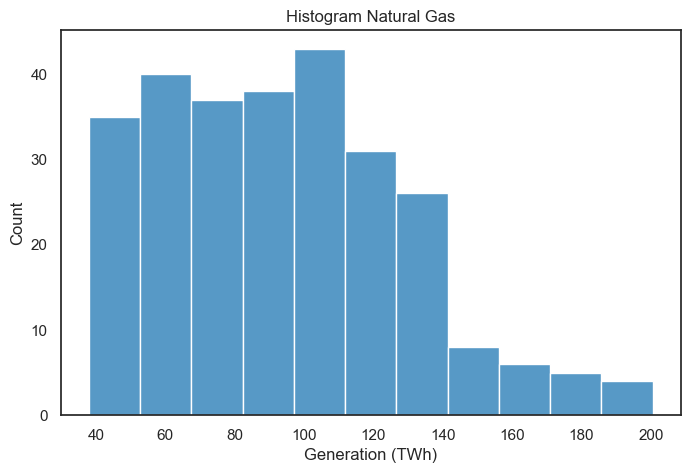

In [ ]:
sns.set_style("white")
plt.figure(figsize=(8,5))
sns.histplot(US_nat['Generation (TWh)'])
plt.title('Histogram Natural Gas')


<Axes: title={'center': 'Density Plot Natural Gas'}, ylabel='Density'>

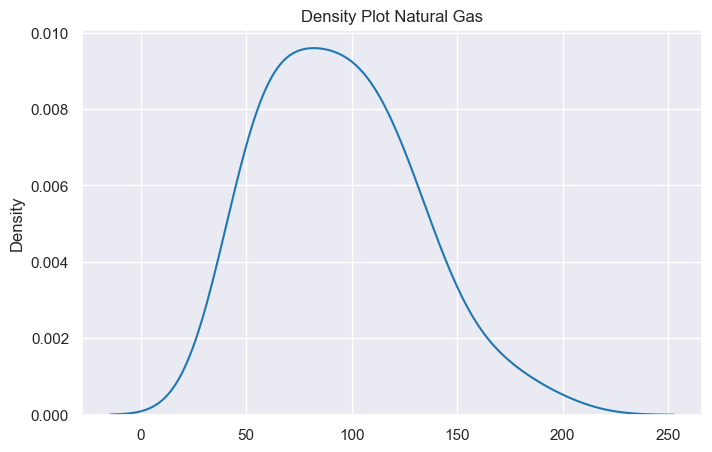

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
plt.title('Density Plot Natural Gas')
sns.kdeplot(np.array(US_nat['Generation (TWh)']), bw_method=0.5)

do a 3 subplots for large med and small

Who creates the most power? By state? By type of producer?

Now that we have looked at the totals we want to look net generation by state. So we dont double count any values we will make a DataFrame that is the inverse of the totals DataFrame by taking out all of the US-Total values. 

Similar to how we separated the totals from the rest of the data we will pull 

In [ ]:
df.head()

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,Generation (TWh)
DATE,,,,
2001-01-01,AK,Total Electric Power Industry,Coal,0.046903
2001-01-01,AK,Total Electric Power Industry,Petroleum,0.071085
2001-01-01,AK,Total Electric Power Industry,Natural Gas,0.367521
2001-01-01,AK,Total Electric Power Industry,Hydroelectric Conventional,0.104549
2001-01-01,AK,Total Electric Power Industry,Wind,0.000087


In [ ]:
state_df = df[(df['STATE'] != 'US-TOTAL') & 
              (df['TYPE OF PRODUCER'] != 'Total Electric Power Industry') & 
              (df['ENERGY SOURCE'] == 'Total')]

NameError: name 'df' is not defined

Make some more DataFrames by grouping by states: month year and all-time

In [ ]:
state_total_month =state_df.groupby(by=[state_df.index,"STATE"]).sum().reset_index()
state_total_year =state_df.groupby(by=[state_df.index.year,"STATE"]).sum().reset_index()
state_total_alltime =state_df.groupby(by=["STATE"]).sum().reset_index().sort_values(by='Generation (TWh)')
state_total_alltime.shape

(51, 4)

The shape of the all time 

By sorting the values we can see the state that has produced the most electricity in the last 22 years cumulative.

In [ ]:
TimePeriodOfData = (state_df.index.year.unique().max()) - (state_df.index.year.unique().min())
TimePeriodOfData


22

In [ ]:
state_total_alltime['AVG Generation'] = state_total_alltime['Generation (TWh)']/TimePeriodOfData
state_total_alltime['Percent of total US generation'] = (state_total_alltime['Generation (TWh)']/state_total_alltime['Generation (TWh)'].sum())
state_total_alltime['Percent of total US generation'] = (state_total_alltime['Percent of total US generation'] * 100).map("{:.2f}%".format)


state_total_alltime[['STATE','Generation (TWh)','AVG Generation','Percent of total US generation']].sort_values(by= 'Generation (TWh)',ascending = False).head(5)


,STATE,Generation (TWh),AVG Generation,Percent of total US generation
43,TX,19789.777967,899.535362,10.73%
9,FL,10436.581495,474.390068,5.66%
38,PA,10072.402110,457.836460,5.46%
4,CA,9136.977502,415.317159,4.95%
14,IL,8683.232698,394.692395,4.71%


In [ ]:
state_total_month_top10=state_total_alltime[['STATE','Generation (TWh)']].sort_values(by='Generation (TWh)', ascending=False).iloc[:10]
state_total_month_top10[['STATE','Generation (TWh)']]

,STATE,Generation (TWh)
43,TX,19789.777967
9,FL,10436.581495
38,PA,10072.402110
4,CA,9136.977502
14,IL,8683.232698
1,AL,6522.395376
35,OH,6218.475825
34,NY,6177.042475
10,GA,5861.743474
27,NC,5765.615731


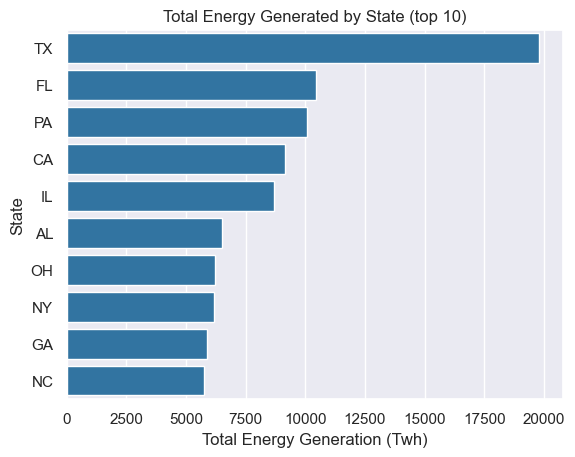

In [ ]:
sns.barplot(x='Generation (TWh)', y='STATE', data=state_total_month_top10,errorbar=None)
sns.color_palette("tab10")
plt.xlabel('Total Energy Generation (Twh)')
plt.ylabel('State')
plt.title('Total Energy Generated by State (top 10)')

plt.show()

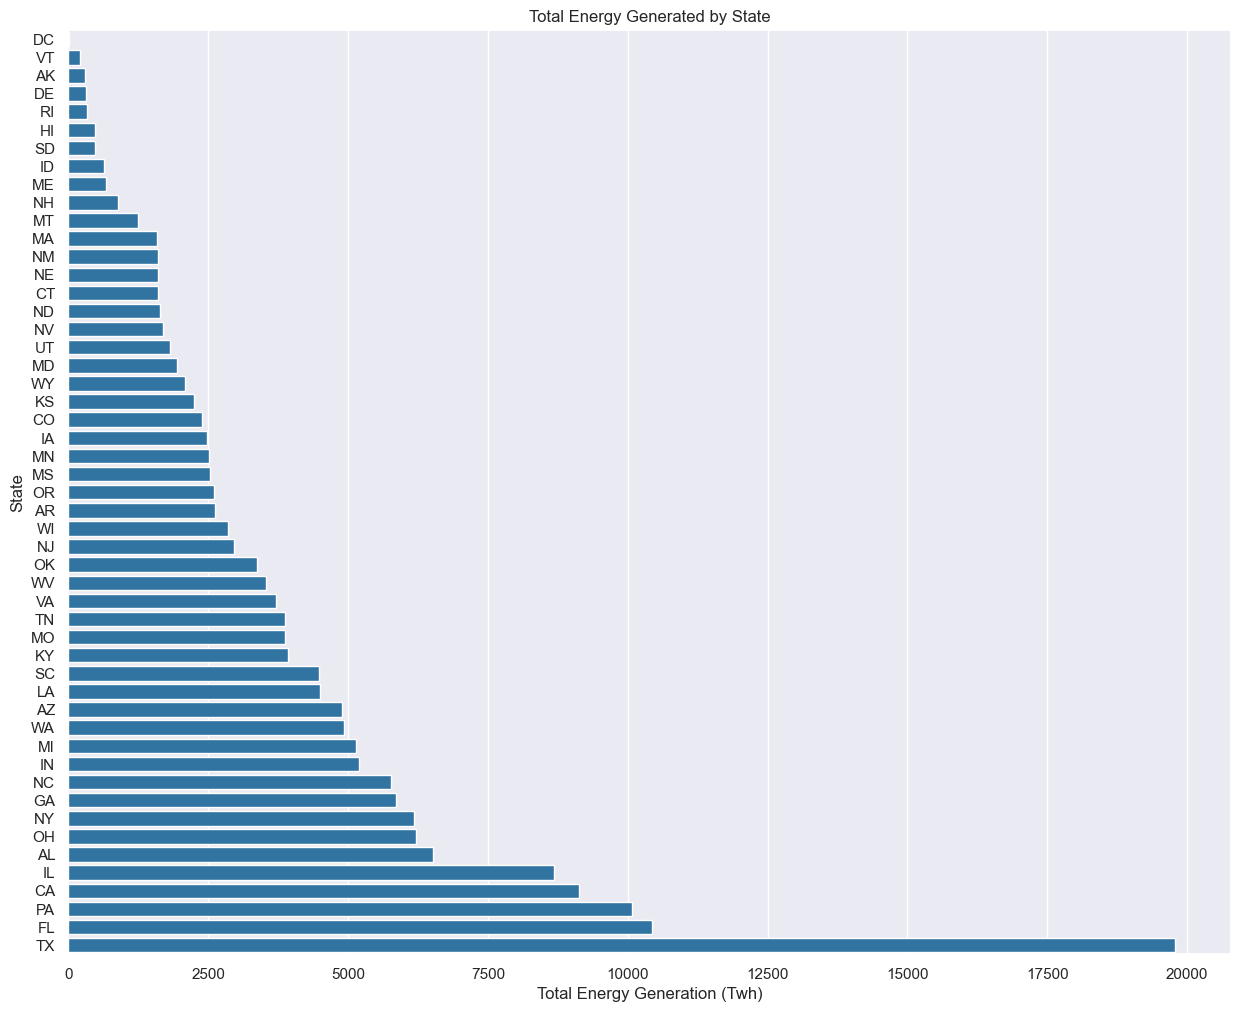

In [ ]:
plt.figure(figsize=(15, 12))
sns.barplot(x='Generation (TWh)', y='STATE', data=state_total_alltime,errorbar=None)
plt.xlabel('Total Energy Generation (Twh)')
plt.ylabel('State')
plt.title('Total Energy Generated by State')

plt.show()

In [ ]:
#need to check if the TEPI is the sume of the others. if so we need to take it out of the state_df, i have a feeling it is

In [ ]:
df[(df['STATE'] == 'US-TOTAL')]

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,Generation (TWh)
DATE,,,,
2001-01-01,US-TOTAL,Total Electric Power Industry,Coal,177.287111
2001-01-01,US-TOTAL,Total Electric Power Industry,Petroleum,18.111843
2001-01-01,US-TOTAL,Total Electric Power Industry,Natural Gas,42.388663
2001-01-01,US-TOTAL,Total Electric Power Industry,Other Gases,0.718442
2001-01-01,US-TOTAL,Total Electric Power Industry,Nuclear,68.707077
...,...,...,...,...
2023-09-01,US-TOTAL,"Electric Generators, Electric Utilities",Petroleum,1.173540
2023-09-01,US-TOTAL,"Electric Generators, Electric Utilities",Solar Thermal and Photovoltaic,1.941910
2023-09-01,US-TOTAL,"Electric Generators, Electric Utilities",Other Biomass,0.078999


In [ ]:

df[(df['STATE'] == 'US-TOTAL') & (df['TYPE OF PRODUCER'] == 'Total Electric Power Industry')]


,STATE,TYPE OF PRODUCER,ENERGY SOURCE,Generation (TWh)
DATE,,,,
2001-01-01,US-TOTAL,Total Electric Power Industry,Coal,177.287111
2001-01-01,US-TOTAL,Total Electric Power Industry,Petroleum,18.111843
2001-01-01,US-TOTAL,Total Electric Power Industry,Natural Gas,42.388663
2001-01-01,US-TOTAL,Total Electric Power Industry,Other Gases,0.718442
2001-01-01,US-TOTAL,Total Electric Power Industry,Nuclear,68.707077
...,...,...,...,...
2023-09-01,US-TOTAL,Total Electric Power Industry,Petroleum,1.620178
2023-09-01,US-TOTAL,Total Electric Power Industry,Solar Thermal and Photovoltaic,15.529558
2023-09-01,US-TOTAL,Total Electric Power Industry,Other Biomass,1.255874


In [ ]:
type_producer[['TYPE OF PRODUCER','Generation (TWh)']]

,TYPE OF PRODUCER,Generation (TWh)
0,"Combined Heat and Power, Commercial Power",494.209903
1,"Combined Heat and Power, Electric Power",7227.805086
2,"Combined Heat and Power, Industrial Power",6598.342559
3,"Electric Generators, Electric Utilities",108543.919514
4,"Electric Generators, Independent Power Producers",61627.402677
5,Total Electric Power Industry,184491.679315


In [ ]:
df_2022 = df_no_US_total.loc['2022']
type_producer_2022 =df_2022.groupby(by=["TYPE OF PRODUCER"]).sum().reset_index()
type_producer_2022[['TYPE OF PRODUCER','Generation (TWh)']]

,TYPE OF PRODUCER,Generation (TWh)
0,"Combined Heat and Power, Commercial Power",33.474523
1,"Combined Heat and Power, Electric Power",259.006709
2,"Combined Heat and Power, Industrial Power",280.085502
3,"Electric Generators, Electric Utilities",4459.221146
4,"Electric Generators, Independent Power Producers",3429.556623
5,Total Electric Power Industry,8461.344480
